# Recap

### Векторные представления

#### Что нужно сделать, чтобы получить векторные представления слов?

In [ ]:
import torch
import torch.nn as nn

import tqdm.auto as tqdm


In [ ]:
def count_params(torch_model):
    return sum([ p.numel() for p in torch_model.parameters() if p.requires_grad ])

# [nn.Embeddings](https://pytorch.org/docs/stable/generated/torch.nn.Embedding.html)

In [ ]:
# dict
word1 -> 0
word2 -> 1
word3 -> 3


мама мыла раму -> [ 100 , 500, 1000 ] -> [ [ 0.1, 0.004... ], [ ...], [ ... ] ]

In [ ]:
(num_embeddings x emb_dim)[i, :]

In [ ]:
nn_embeddings = nn.Embedding(num_embeddings=len(ascii_lowercase), embedding_dim=100)

tokens_batch_embedded = nn_embeddings(tokens_batch)
tokens_batch_embedded.shape

torch.Size([6, 13, 100])

# [nn.RNN](https://pytorch.org/docs/stable/generated/torch.nn.RNN.html)

На прошлом семе мы смотрели на подделку на RNN

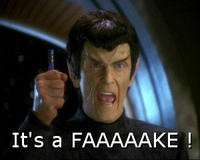

In [ ]:
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)

        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

n_hidden = 128
n_letters = 26
n_categories = 10
rnn = RNN(n_letters, n_hidden, n_categories)

### PyTorch Реализация

In [ ]:
rnn = nn.RNN(10, 20, 2)
input = torch.randn(5, 3, 10)
h0 = torch.randn(2, 3, 20)
output, hn = rnn(input, h0)

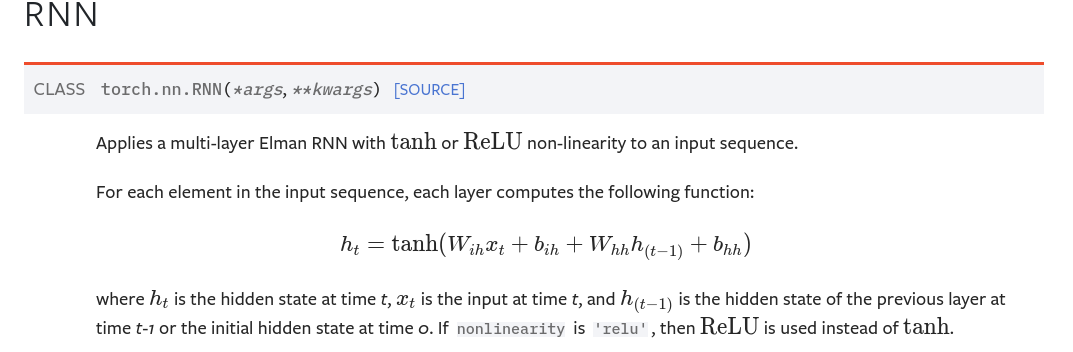

##### Что такое `output` и `hn`?

In [ ]:
# seq_len, batch_size, hidden_dim
output.shape

(torch.Size([5, 3, 20]), torch.Size([2, 3, 20]))

In [ ]:
# D * num_layers, batch_size, hidden_dim
# where D = 2 if bidirectional else 1
hn.shape

torch.Size([2, 3, 20])

In [ ]:
(output[-1, :, :] == hn[-1, :, :]).all()

tensor(True)

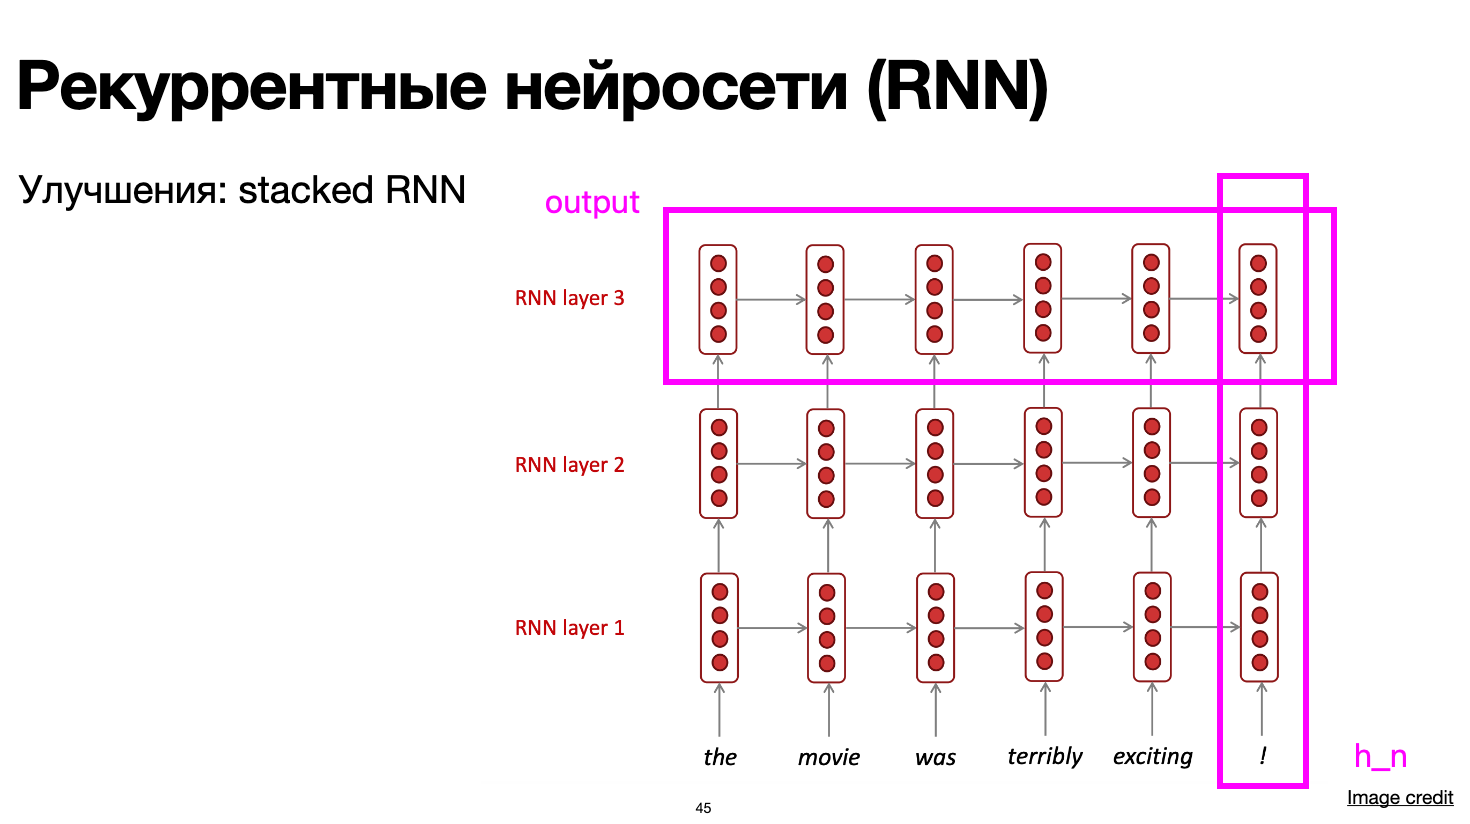

##### **Вопрос:** Зачем тогда возвращать hn, если можно просто сделать `output[-1, :, :]`

#### Посмотрим, какие параметры есть в рннке

In [ ]:
# (W_ih W_hh, b_ih, b_hh) * 2

parameters_names = [ 'W_ih', 'W_hh', 'b_ih', 'b_hh' ] * 2
for name, p_shape in zip(parameters_names, list(map(lambda x: x.shape, rnn.parameters()))):
    print(name, ":", p_shape)

W_ih : torch.Size([20, 10])
W_hh : torch.Size([20, 20])
b_ih : torch.Size([20])
b_hh : torch.Size([20])
W_ih : torch.Size([20, 20])
W_hh : torch.Size([20, 20])
b_ih : torch.Size([20])
b_hh : torch.Size([20])


#### Кол-во параметров


In [ ]:
count_params(rnn)

1480

### Своя реализация

In [ ]:
import torch.nn as nn

class MyRNN(nn.Module):

    def __init__(self, input_size, hidden_size, num_layers):
        super(MyRNN, self).__init__()

        assert num_layers == 1, "num_layers > 1 not implemented"

        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size, hidden_size) 
        self.h2h = nn.Linear(hidden_size, hidden_size)

    def forward(self, input, hidden):
        # input [ seq_len, batch_size, input_dim ]
        # hidden [ D * num_layers, hidden_dim ] # here always D * num_layers == 1

        output = []

        for i in range(input.shape[0]):
            output.append(hidden)

            #                      W_i2h + b_i2h          +  W_h2h + b_h2h
            # for n in self.n_layers
            hidden = torch.tanh( self.i2h(input[i, :, :]) + self.h2h(hidden) )
        
        output = torch.cat(output) # [ seq-len, bs, hid_dim ] 
        return output, hidden

n_hidden = 128
n_letters = 26
n_categories = 10
rnn = MyRNN(n_letters, n_hidden, n_categories)

**Вопрос:** что надо сделать, чтобы поддержать `num_layers > 1`?

# [nn.LSTM](https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html#torch.nn.LSTM)

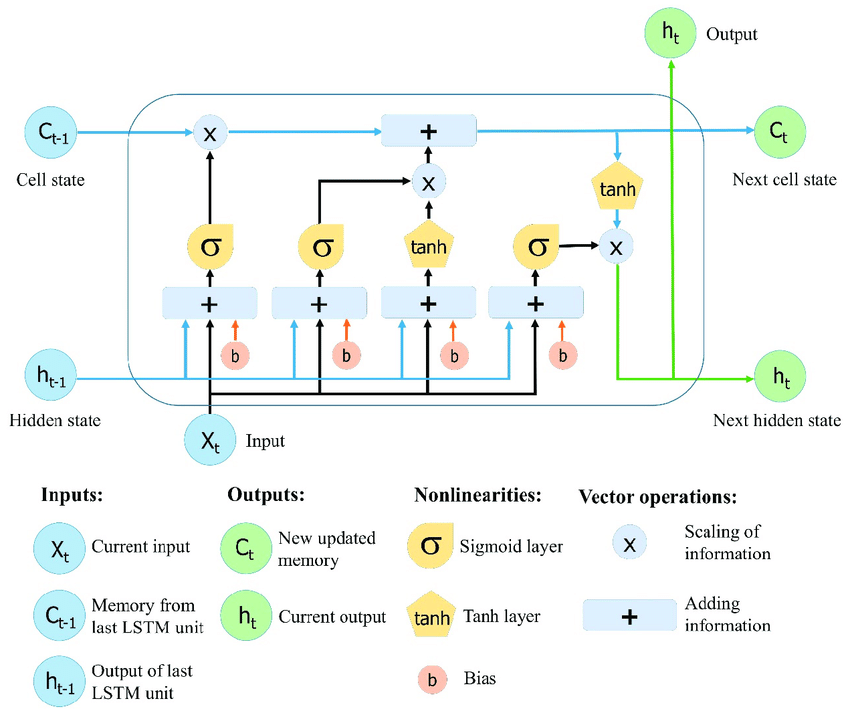

In [ ]:
lstm = nn.LSTM(10, 20, 2)

input = torch.randn(5, 3, 10)   # [ seq_len, batch_size, input_dim ]
h0 = torch.randn(2, 3, 20)      # [ num_layers * D, batch_size, hidden_dim ] # where D=2 if bidirectional else 1
c0 = torch.randn(2, 3, 20)      # shape like h0
output, (hn, cn) = lstm(input, (h0, c0))

In [ ]:
output.shape, hn.shape, cn.shape

(torch.Size([5, 3, 20]), torch.Size([2, 3, 20]), torch.Size([2, 3, 20]))

In [ ]:
(output[-1, :, :] == hn[-1, :, :]).all()

tensor(True)

#### Кол-во параметров


In [ ]:
count_params(lstm)

5920

# [nn.GRU](https://pytorch.org/docs/stable/generated/torch.nn.GRU.html#torch.nn.GRU)

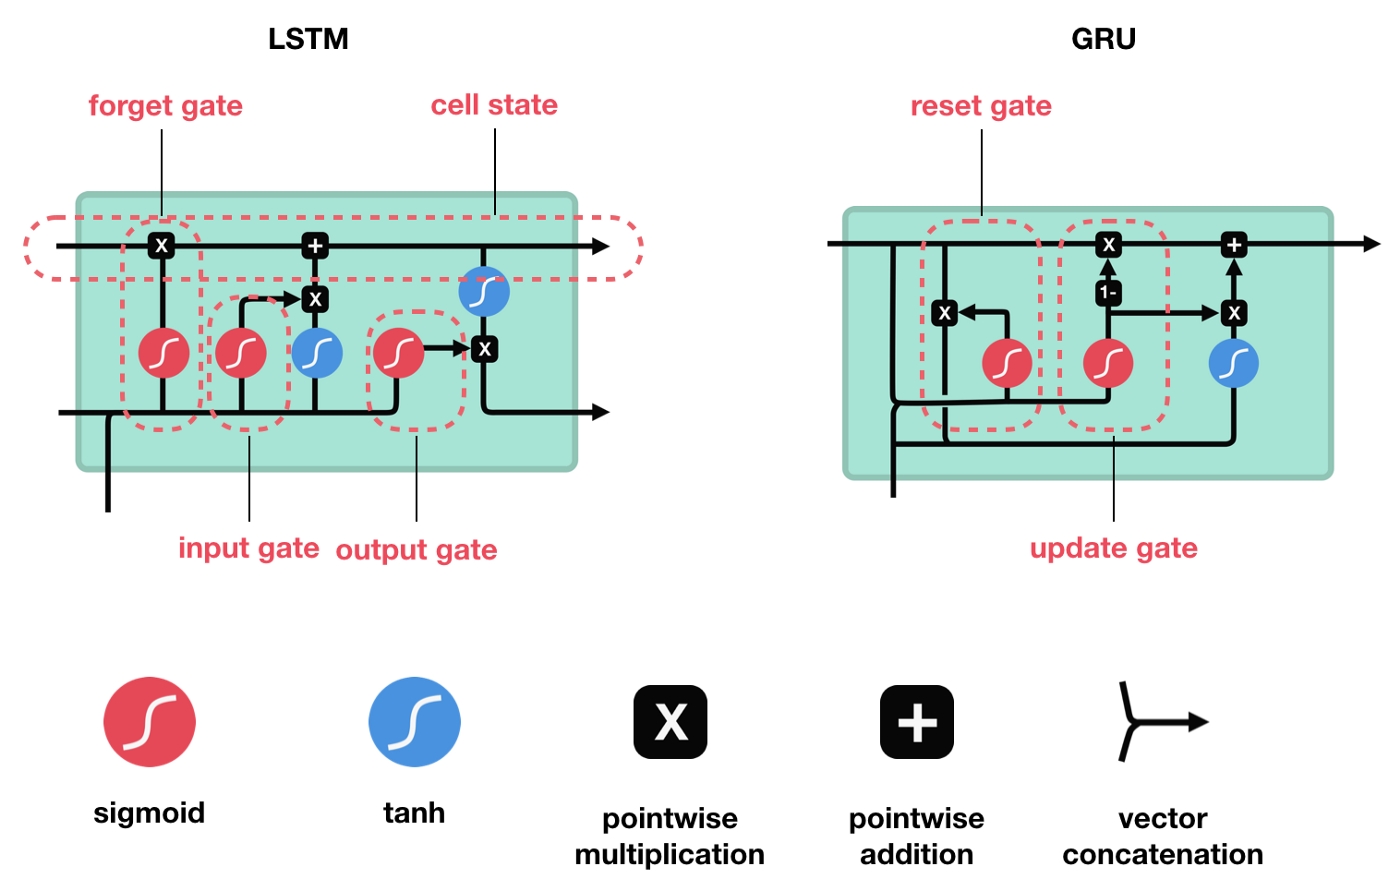

In [ ]:
gru = nn.GRU(10, 20, 2)
input = torch.randn(5, 3, 10)
h0 = torch.randn(2, 3, 20)
output, hn = gru(input, h0)

#### Кол-во параметров


In [ ]:
count_params(gru)

4440

# Задача POS-tagging

#### **Вопрос**: чем LSTM/RNN лучше/хуже для задачи POS-tagging'а, чем MLP классификатор?


#### В отдельном [**ноутбуке**](https://colab.research.google.com/drive/1DMydkEt3mg8MagsMoitWHDUUWcjRa9Cd?usp=sharing)



Оригинальный [туториал](https://pytorch.org/tutorials/beginner/nlp/sequence_models_tutorial.html)



# Статьи

* [Memorization in RNNs](https://distill.pub/2019/memorization-in-rnns/)
* [Illustrated Guide to LSTM’s and GRU’s: A step by step explanation](https://towardsdatascience.com/illustrated-guide-to-lstms-and-gru-s-a-step-by-step-explanation-44e9eb85bf21)

# Блиц

## Какие проблемы есть у RNN?

<!--
* долго обучается и вычисляется (а почему?)
* затухающие градиенты
* плохо работают с долгосрочными зависимостями (помнят лишь небольшой контекст)
* контекст учитывается только слева направо
-->


## Как они решаются с в LSTM?




## Чем GRU лучше LSTM?

## Чем `LSTM(..., bidirectional=True)` отличается от `LSTM(..., num_layers=2)`


## Чем `RNN(..., bidirectional=True)` отличается от `RNN(..., num_layers=2)`

### Как сгенерировать последовательность, которая бы отличалась по длинне от исходной последовательности?

<!--

* Можно придумать пустой токен и генерировать последовательность заведомо большей длинны
* Можно ввести токен онокчания последовательности <EOS> (end of sequence token). Генерировать пока сеть не предскажет именно токен окончания последовательности


 -->



**bold text**# Вопросы по домашкам?